In [ ]:
!echo "Last updated: `date`"

Last updated: Sun Aug 16 16:36:13 UTC 2020


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from sklearn.datasets import make_moons
from tqdm import trange

sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Alias.
SqExpKernel = tfp.math.psd_kernels.ExponentiatedQuadratic

# Default data type for tensorflow tensors.
# dtype = np.float32
dtype = np.float64

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set number of cores.
# tf.config.threading.set_inter_op_parallelism_threads(4)

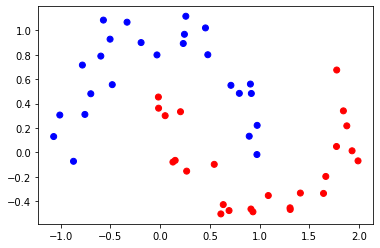

In [ ]:
def plot_data(X, y, **kwargs):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], **kwargs)

# Make data
X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
X = X.astype(dtype)
plot_data(X, y)

In [ ]:
# gp = tfd.GaussianProcess(kernel=SqExpKernel(1, .5), index_points=X.astype(np.float32))  # index_points needs to be (at least?) 2D.
# gp.sample([10, 3]).shape  # should be 10 x 3 x X.shape[0]
# gp.sample()  # shouold be X.shape[0]
# gp.log_prob(np.random.randn(2, 3, 50))  # This should work as long as last dimensions is X.shape[0]
# tfd.GaussianProcess(SqExpKernel(1,.5), mean_fn=lambda x: 0.0, index_points=X.astype(np.float32)).sample()

In [ ]:
# Specify GP model 

# NOTE: This version mixes poorly.

# gpc_model = tfd.JointDistributionNamed(dict(
#     alpha=tfd.LogNormal(dtype(0), dtype(1)),
#     rho=tfd.LogNormal(dtype(0), dtype(1)),
#     beta=tfd.Normal(dtype(0), dtype(1)),
#     f=lambda alpha, rho, beta: tfd.GaussianProcess(
#         mean_fn=lambda x: beta[..., tf.newaxis] + np.zeros(x.shape[0]),
#         kernel=SqExpKernel(amplitude=alpha, length_scale=rho, feature_ndims=1),
#         jitter=1e-3, index_points=X),
#     obs=lambda f: tfd.Independent(
#         tfd.Bernoulli(logits=f), reinterpreted_batch_ndims=1)
# ))

def compute_LK(alpha, rho, X, jitter=1e-6):
    kernel = SqExpKernel(alpha, rho)
    K = kernel.matrix(X, X) + tf.eye(X.shape[0], dtype=dtype) * jitter
    return tf.linalg.cholesky(K)

def compute_f(alpha, rho, beta, eta):
    LK = compute_LK(alpha, rho, X)
    f = LK @ tf.expand_dims(eta, -1)
    return f[..., 0] + beta[..., tf.newaxis]

gpc_model = tfd.JointDistributionNamed(dict(
    alpha=tfd.LogNormal(dtype(0), dtype(1)),
    rho=tfd.LogNormal(dtype(0), dtype(1)),
    beta=tfd.Normal(dtype(0), dtype(1)),
    eta=tfd.Independent(
        tfd.Normal(np.zeros(X.shape[0], dtype=dtype), dtype(1)),
        reinterpreted_batch_ndims=1),
    obs=lambda alpha, rho, beta, eta: tfd.Independent(
        tfd.Bernoulli(logits=compute_f(alpha, rho, beta, eta)),
        reinterpreted_batch_ndims=1) 
))

print(gpc_model.sample()['obs'].shape)
print(gpc_model.sample()['eta'].shape)
print(gpc_model.sample([2])['obs'].shape)
print(gpc_model.sample([2])['eta'].shape)
print(gpc_model.sample([2,3])['obs'].shape)
print(gpc_model.sample([2,3])['eta'].shape)

# s = gpc_model.sample([2, 3])
# gpc_model.log_prob(s)
# gpc_model.log_prob(amplitude=dtype(1), length_scale=dtype(0.5),
#                    intercept=dtype(0), f=np.random.randn(50).astype(dtype),
#                    obs=_y)

(50,)
(50,)
(2, 50)
(2, 50)
(2, 3, 50)
(2, 3, 50)


In [ ]:
# Run graph to make sure it works.
_ = gpc_model.sample()
# _ = gpc_model.sample([2])

# Initial values.
initial_state = [
    1 * tf.ones([], dtype=dtype, name='alpha'),
    0.5 * tf.ones([], dtype=dtype, name='rho'),
    tf.zeros([], dtype=dtype, name='beta'),
    tf.zeros(X.shape[0], dtype=dtype, name='eta'),
]

# Bijectors (from unconstrained to constrained space)
bijectors = [
    tfp.bijectors.Exp(),  # alpha
    tfp.bijectors.Exp(),  # rho
    tfp.bijectors.Identity(),  # beta
    tfp.bijectors.Identity(),  # eta
]

# Unnormalized log posterior
def unnormalized_log_posterior(alpha, rho, beta, eta):
    return gpc_model.log_prob(alpha=alpha, rho=rho, beta=beta, eta=eta, obs=y)

In [ ]:
# Test.
unnormalized_log_posterior(initial_state[0], initial_state[1],
                           initial_state[2], initial_state[3])

<tf.Tensor: shape=(), dtype=float64, numpy=-82.90818061424406>

In [ ]:
# @tf.function(autograph=False, experimental_compile=True)  # 33s
# @tf.function(autograph=False)  # 13s
@tfp.experimental.nn.util.tfcompile  # 14s
def run_hmc(num_results, num_burnin_steps):
      return tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=initial_state,
          kernel=tfp.mcmc.TransformedTransitionKernel(
                     inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                         target_log_prob_fn=unnormalized_log_posterior,
                         step_size=0.05,
                         num_leapfrog_steps=20),
                     bijector=bijectors),
          trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

In [ ]:
# set random seed
tf.random.set_seed(2)

# Compile
%time _ = run_hmc(1, 1)

# Run
%time [alpha, rho, beta, eta], is_accepted = run_hmc(500, 500)

# Print acceptance rate.
print("Acceptance rate: {}".format(np.mean(is_accepted)))

# Collect posterior samples.
hmc_samples = dict(alpha=alpha.numpy(), rho=rho.numpy(),
                   beta=beta.numpy(), eta=eta.numpy())

CPU times: user 3.44 s, sys: 83.6 ms, total: 3.52 s
Wall time: 3.43 s
CPU times: user 16.2 s, sys: 511 ms, total: 16.7 s
Wall time: 11.1 s
Acceptance rate: 0.882


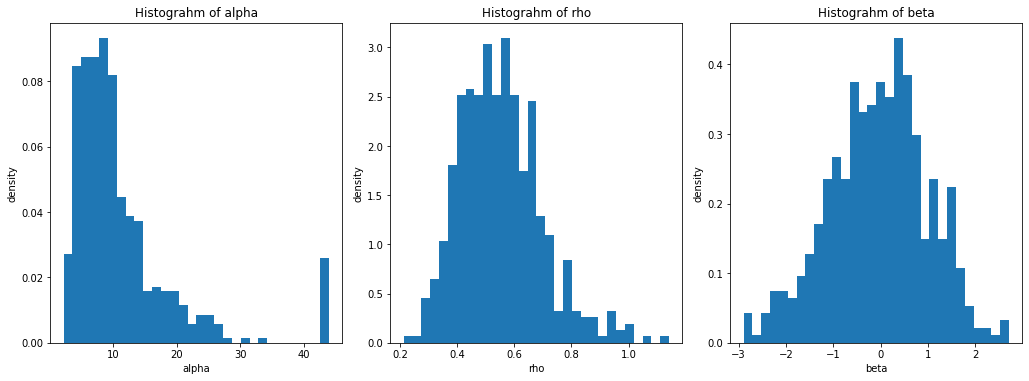

In [ ]:
plt.figure(figsize=np.array([8, 3]) * 1.8)
kernel_params = ['alpha', 'rho', 'beta']
for i in range(len(kernel_params)):
    plt.subplot(1, len(kernel_params), i+1)
    param = kernel_params[i]
    plt.hist(hmc_samples[param], bins=30, density=True)
    plt.xlabel(param)
    plt.ylabel('density')
    plt.title("Histograhm of {}".format(param))
plt.tight_layout()

In [ ]:
def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

index_points, x0, x1 = gen_grid(X, 30, return_each=True, eps=0.5)

In [ ]:
def onepred(i):
    f = compute_f(alpha[i], rho[i], beta[i], eta[i])
    gprm = tfd.GaussianProcessRegressionModel(kernel=SqExpKernel(alpha[i],rho[i]),
                                              index_points=index_points.astype(dtype),
                                              observation_index_points=X,
                                              jitter=1e-6,
                                              observations=f)

    return gprm.sample().numpy()
preds = np.stack([onepred(i) for i in trange(500)])

100%|██████████| 500/500 [00:44<00:00, 11.25it/s]


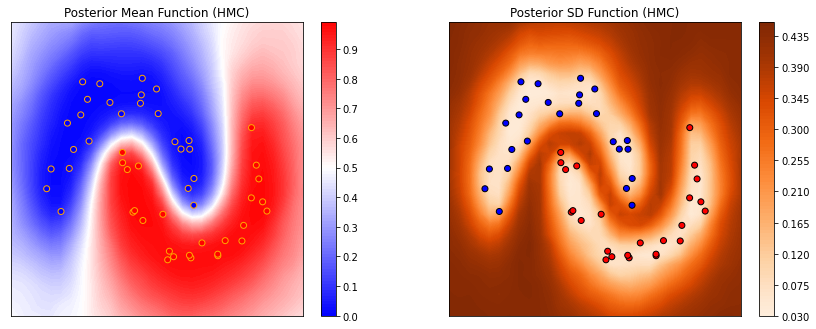

In [ ]:
plt.figure(figsize=np.array([8, 3]) * 1.8)
# Plot mean function.
plt.subplot(1, 2, 1)
plt.contourf(x0, x1, sigmoid(preds).mean(0).reshape(x0.shape), 101,
             cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar();
plot_data(X, y, edgecolors='orange');
plt.xticks([]); plt.yticks([]);
plt.title("Posterior Mean Function ({})".format('HMC'));

# Plot SD function.
plt.subplot(1, 2, 2)
plt.contourf(x0, x1, sigmoid(preds).std(0).reshape(x0.shape), 101,
             cmap=plt.get_cmap('Oranges'), vmin=0)
plt.colorbar();
plot_data(X, y, edgecolors='black');
plt.xticks([]); plt.yticks([]);
plt.title("Posterior SD Function ({})".format('HMC'));